In [65]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import csv
import random
import math

In [66]:
random.seed(42)

In [67]:
device = torch.device('cuda')
device

device(type='cuda')

In [68]:
class MusicDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

def pad_collate(batch):
    sequences, targets = zip(*batch)
    seq_lengths = [len(seq) for seq in sequences]
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=-2)
    return padded_sequences, torch.tensor(targets), seq_lengths

In [69]:
with open('train.pkl', 'rb') as f:
    train_data = pickle.load(f)

sequences, targets = zip(*train_data)

label_encoder = LabelEncoder()
encoded_targets = label_encoder.fit_transform(targets)

sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
encoded_targets = torch.tensor(encoded_targets, dtype=torch.long)

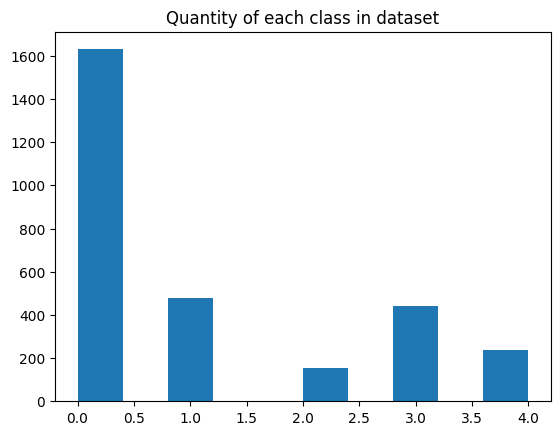

In [70]:
plt.hist(encoded_targets)
plt.title("Quantity of each class in dataset")
plt.show()

In [71]:
train_ratio = 0.8
num_samples = len(sequences)
train_size = int(train_ratio * num_samples)

random_indices = list(range(num_samples))
random.shuffle(random_indices)

train_indices = random_indices[:train_size]
test_indices = random_indices[train_size:]

train_sequences = [sequences[i] for i in train_indices]
train_encoded_targets = torch.tensor([encoded_targets[i] for i in train_indices])
test_sequences = [sequences[i] for i in test_indices]
test_encoded_targets = torch.tensor([encoded_targets[i] for i in test_indices])

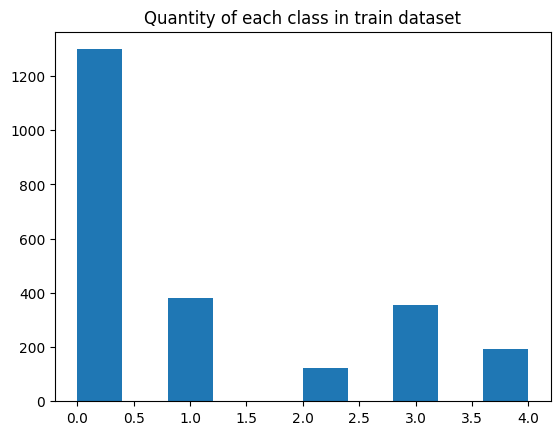

In [72]:
plt.hist(train_encoded_targets)
plt.title("Quantity of each class in train dataset")
plt.show()

In [73]:
dupl_1 = math.floor(train_encoded_targets.tolist().count(0)/train_encoded_targets.tolist().count(1)-1)
dupl_2 = math.floor(train_encoded_targets.tolist().count(0)/train_encoded_targets.tolist().count(2)-1)
dupl_3 = math.floor(train_encoded_targets.tolist().count(0)/train_encoded_targets.tolist().count(3)-1)
dupl_4 = math.floor(train_encoded_targets.tolist().count(0)/train_encoded_targets.tolist().count(4)-1)

duplicate = {1:dupl_1, 2:dupl_2, 3:dupl_3, 4:dupl_4}

sequences_duplicated = []
encoded_duplicated = []

for class_number in duplicate:
    mask = (train_encoded_targets == class_number)
    indices = torch.nonzero(mask)
    for i in indices:
        
        seq = train_sequences[i]
        enc = class_number
        for _ in range(0, duplicate[class_number]):
            sequences_duplicated.append(seq)
            encoded_duplicated.append(enc)

sequences_extended = train_sequences.copy()
sequences_extended.extend(sequences_duplicated)
encoded_targets_extended = torch.cat((train_encoded_targets, torch.tensor(encoded_duplicated)), 0)

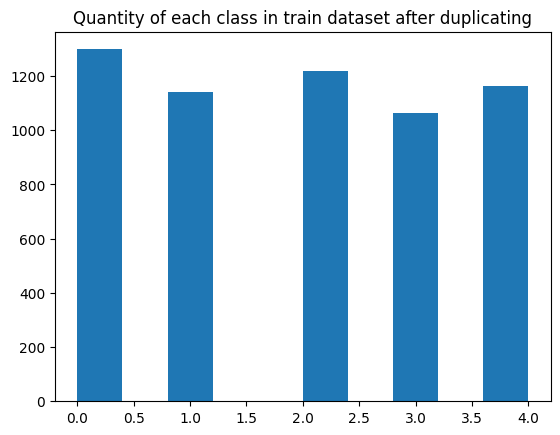

In [74]:
plt.hist(encoded_targets_extended)
plt.title("Quantity of each class in train dataset after duplicating")
plt.show()

In [75]:
batch_size = 256

In [76]:
final_sequence = sequences_extended.copy()
final_sequence.extend(test_sequences)

In [77]:
train_dataset = MusicDataset(sequences_extended, encoded_targets_extended)
test_dataset = MusicDataset(test_sequences, test_encoded_targets)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

final_sequence = sequences_extended.copy()
final_sequence.extend(test_sequences)

dataset = MusicDataset(final_sequence, torch.cat((encoded_targets_extended, test_encoded_targets)))

In [78]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_out, (hidden, _) = self.lstm(packed_x)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = hidden[-1]
        out = self.dropout(out)
        out = self.fc(out)
        return out

input_size = 1
hidden_size = 128
num_layers = 2
num_classes = len(label_encoder.classes_)

## Badanie dokładności 

Epoch [0/300], Loss: 1.5693, Test Accuracy: 0.3639
F score: class 0: 0.4868 	 class 1: 0.2131	 class 2: 0.2022 	 class 3: 0.3377 	 class 4: 0.1609
Epoch [1/300], Loss: 1.4732, Test Accuracy: 0.4456
F score: class 0: 0.5849 	 class 1: 0.3978	 class 2: 0.1818 	 class 3: 0.4261 	 class 4: 0.1831
Epoch [2/300], Loss: 1.3670, Test Accuracy: 0.4932
F score: class 0: 0.6786 	 class 1: 0.3399	 class 2: 0.1392 	 class 3: 0.4706 	 class 4: 0.1220
Epoch [3/300], Loss: 1.3358, Test Accuracy: 0.5850
F score: class 0: 0.7556 	 class 1: 0.3467	 class 2: 0.2000 	 class 3: 0.4835 	 class 4: 0.2385
Epoch [4/300], Loss: 1.3243, Test Accuracy: 0.5340
F score: class 0: 0.7147 	 class 1: 0.4105	 class 2: 0.2435 	 class 3: 0.2957 	 class 4: 0.2115
Epoch [5/300], Loss: 1.2857, Test Accuracy: 0.3861
F score: class 0: 0.4913 	 class 1: 0.3385	 class 2: 0.1765 	 class 3: 0.4087 	 class 4: 0.3000
Epoch [6/300], Loss: 1.3000, Test Accuracy: 0.5119
F score: class 0: 0.6808 	 class 1: 0.3484	 class 2: 0.0870 	 class

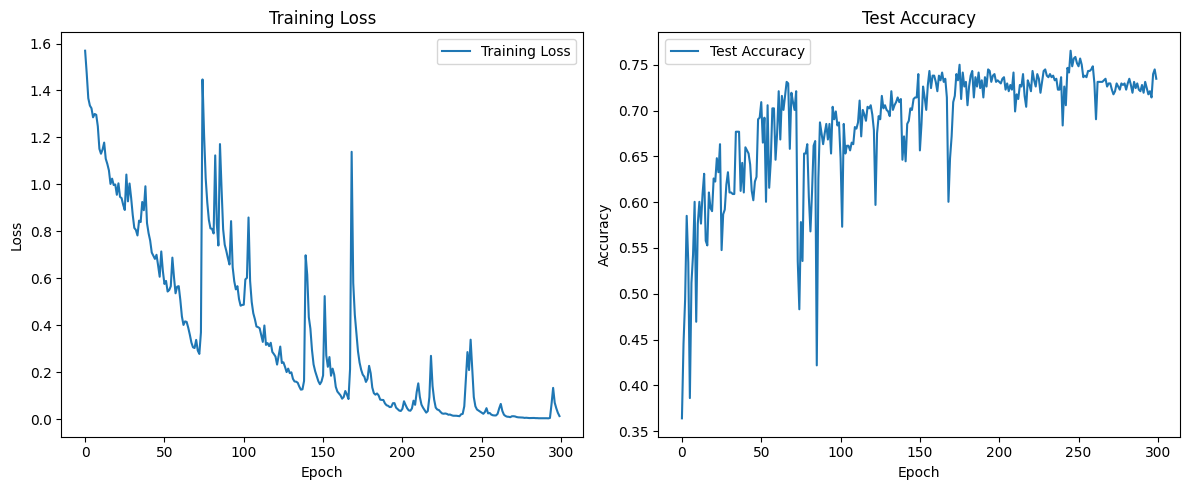

In [79]:
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 300
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for sequences, targets, lengths in train_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        sequences = sequences.unsqueeze(2)
        
        outputs = model(sequences, lengths)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets, lengths in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            sequences = sequences.unsqueeze(2)
            
            outputs = model(sequences, lengths)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    f_score = f1_score(all_targets, all_preds, average=None)
    test_accuracies.append(accuracy)

    print(f'Epoch [{epoch}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Test Accuracy: {accuracy:.4f}')
    print(f'F score: class 0: {f_score[0]:.4f} \t class 1: {f_score[1]:.4f}\t class 2: {f_score[2]:.4f} \t class 3: {f_score[3]:.4f} \t class 4: {f_score[4]:.4f}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Finalny model uczony na pełnym zbiorze treningowym

In [80]:
final_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    for sequences, targets, lengths in final_train_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        sequences = sequences.unsqueeze(2)

        outputs = model(sequences, lengths)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [0/300], Loss: 1.5511
Epoch [1/300], Loss: 1.3984
Epoch [2/300], Loss: 1.2059
Epoch [3/300], Loss: 1.1838
Epoch [4/300], Loss: 1.1837
Epoch [5/300], Loss: 1.1194
Epoch [6/300], Loss: 1.1663
Epoch [7/300], Loss: 0.9704
Epoch [8/300], Loss: 0.7543
Epoch [9/300], Loss: 0.9962
Epoch [10/300], Loss: 1.0430
Epoch [11/300], Loss: 0.8662
Epoch [12/300], Loss: 0.9305
Epoch [13/300], Loss: 0.7393
Epoch [14/300], Loss: 0.8901
Epoch [15/300], Loss: 0.9771
Epoch [16/300], Loss: 0.8610
Epoch [17/300], Loss: 0.8833
Epoch [18/300], Loss: 0.9058
Epoch [19/300], Loss: 0.8259
Epoch [20/300], Loss: 0.6941
Epoch [21/300], Loss: 0.6922
Epoch [22/300], Loss: 0.8202
Epoch [23/300], Loss: 0.6117
Epoch [24/300], Loss: 0.6546
Epoch [25/300], Loss: 0.6032
Epoch [26/300], Loss: 0.5501
Epoch [27/300], Loss: 0.5587
Epoch [28/300], Loss: 0.7814
Epoch [29/300], Loss: 0.5775
Epoch [30/300], Loss: 0.6453
Epoch [31/300], Loss: 0.4773
Epoch [32/300], Loss: 0.6934
Epoch [33/300], Loss: 0.6117
Epoch [34/300], Loss: 0.

In [81]:
with open('test_no_target.pkl', 'rb') as f:
    test_sequences = pickle.load(f)

test_sequences = [torch.tensor(seq, dtype=torch.float32) for seq in test_sequences]
test_dataset = MusicDataset(test_sequences, [0] * len(test_sequences))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

model.eval()
predictions = []

with torch.no_grad():
    for sequences, _, lengths in test_loader:
        sequences = sequences.to(device).unsqueeze(2)
        outputs = model(sequences, lengths)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

predicted_composers = label_encoder.inverse_transform(predictions)
print(predicted_composers)

[1 0 0 ... 1 3 3]


In [82]:
with open('poniedzialek_grądziel_misztal.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for composer in predicted_composers:
        writer.writerow([composer])